In [9]:
!pip freeze > ../requrements.txt

In [1]:
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, sys
import fastcore.all as fc
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
from collections.abc import Mapping, Callable, Iterable
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial, wraps
import copy
from contextlib import contextmanager

import torch
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms.functional as TF
from torcheval.metrics import MulticlassAccuracy, Mean
from datasets import load_dataset, load_dataset_builder
import logging

from fastprogress import progress_bar, master_bar

sys.path.append(os.path.abspath('..'))

/home/korallll/Desktop/diffusion/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'
def_device = 'cpu'

logging.disable(logging.WARNING)

In [3]:
from utils import inplace, to_device, to_cpu
from data_utils import DataLoaders
from metrics import Accuracy, Metric

In [4]:
x, y = 'image', 'label'
name = "fashion_mnist"
dataset = load_dataset(name, trust_remote_code=True)

@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
    
batch_size = 1024

tranformed_dataset = dataset.with_transform(transformi)

In [5]:
dls = DataLoaders.from_dd(tranformed_dataset, batch_size)
train_loader = dls.train
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([1024, 784]), torch.Size([1024]))

In [6]:
acc = Accuracy()
acc.add(tensor([0,1,2,0,1,2]), tensor([0,1,1,2,1,0]))
acc.value

tensor(0.50)

In [7]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32 + 0.9 * 2) / (32+2), 2)

(tensor(0.62), 0.62)

In [8]:
m, nh = 28*28, 50
def get_model(): return nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [9]:
from learners import Learner, MomentumLearner
from callbacks import *
from callbacks.exceptions import *

In [10]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 67 batches


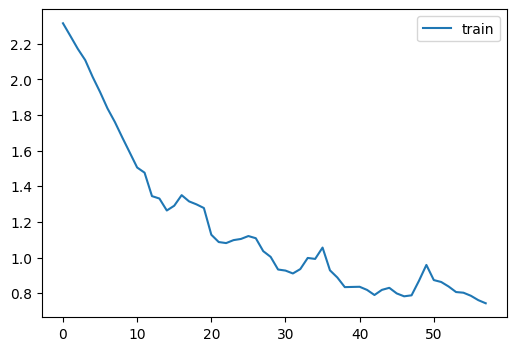

In [12]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

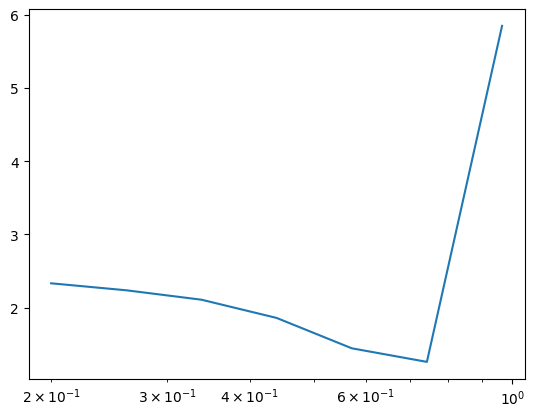

In [10]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

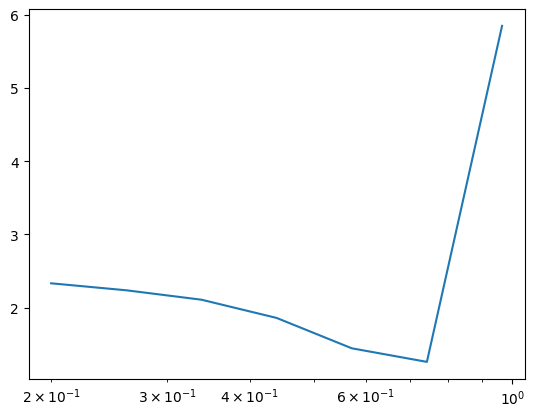

In [11]:
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')